# Prepering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, Markdown
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import Excel data and choose the relevant columns
df = pd.read_excel(r"C:\Users\noy\OneDrive - mail.tau.ac.il\פרויקט מעבדה\project_data.xlsx", sheet_name="the data")

# Ensure the DataFrame contains 'Education' and 'Occupation' columns
df = df[['Education', 'Occupation']]
df['Occupation'] = df['Occupation'].replace({
    'Health professions': 'Healthcare & Rescue Services',
    'Health Professions': 'Healthcare & Rescue Services',
    'rescue services': 'Healthcare & Rescue Services',
    'Science and Eng.': 'Science & Technology',
    'Information Technologies': 'Science & Technology',
    'HighTech': 'Science & Technology',
    'HIghTech': 'Science & Technology',
    'Machine professional': 'Science & Technology',
    'Business and finances': 'Business & Management',
    'Junior management': 'Business & Management',
    'Junior Management': 'Business & Management',
    'Senior Management': 'Business & Management',
    'Service and sales': 'Service & Sales',
    'Agriculture': 'Arts, Sports & Communication',
    'Sports': 'Arts, Sports & Communication',
    'Performing arts': 'Arts, Sports & Communication',
    'Design, craft & cooking': 'Arts, Sports & Communication',
    'journalism and translation': 'Arts, Sports & Communication',
    'Retired': 'Retired and Unemployed',
    'Unemployed': 'Retired and Unemployed',
    'government': 'Government',
})

# Calculate count, total, and percentage for pie charts
count_df = df.groupby(['Education', 'Occupation']).size().reset_index(name='Count')
total_counts = count_df.groupby('Education')['Count'].sum().reset_index(name='Total')
count_df = pd.merge(count_df, total_counts, on='Education')
count_df['Percentage'] = (count_df['Count'] / count_df['Total']) * 100

# Generating Correlations Plots

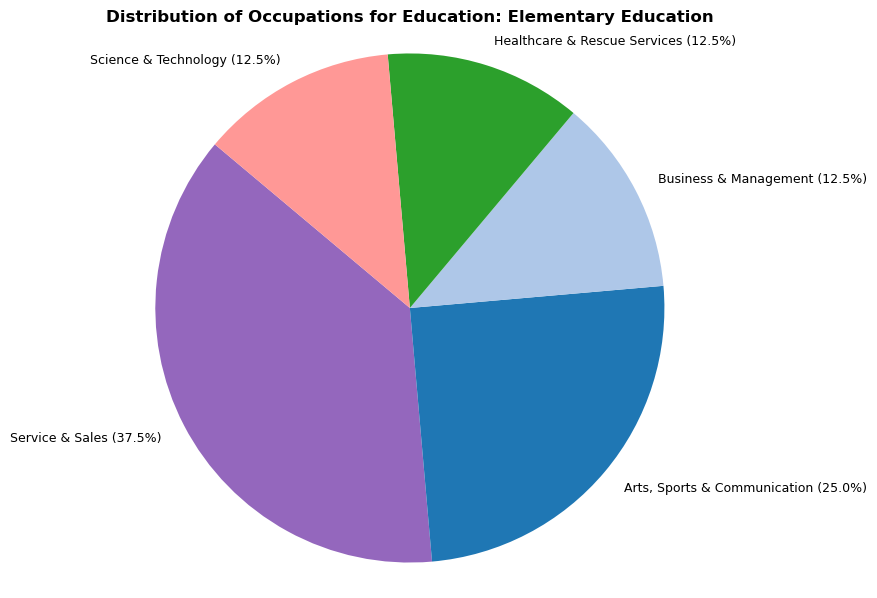

**occupations not found in Elementary Education:** Legal, Student, Government, Education, Retired and Unemployed

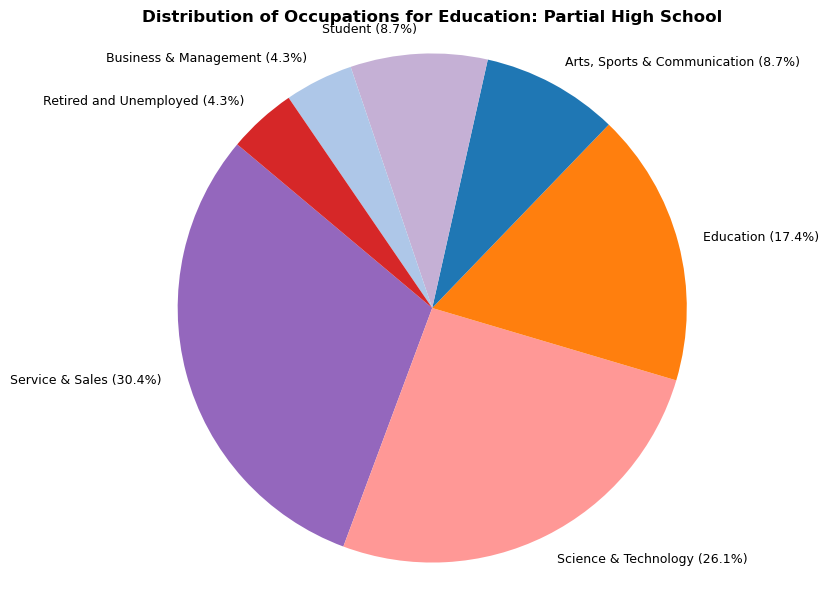

**occupations not found in Partial High School:** Government, Legal, Healthcare & Rescue Services

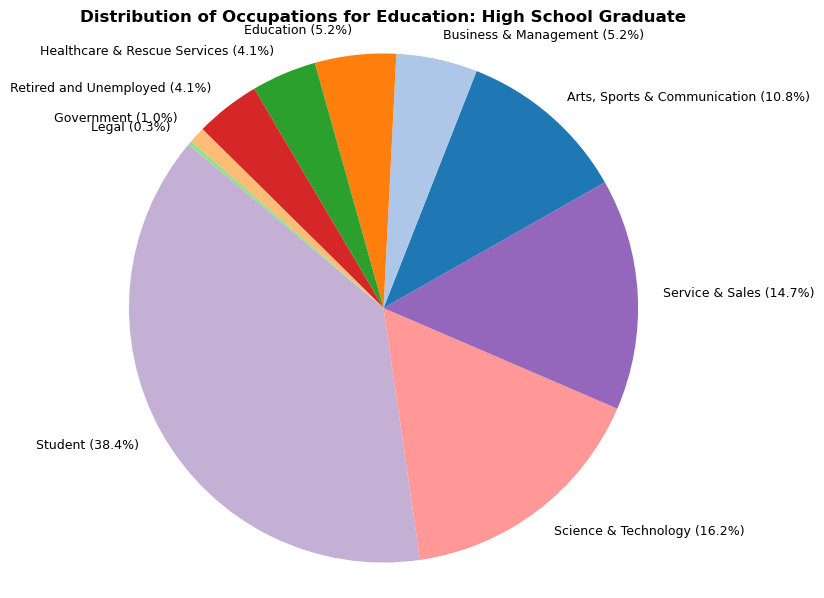

**occupations not found in High School Graduate:** None

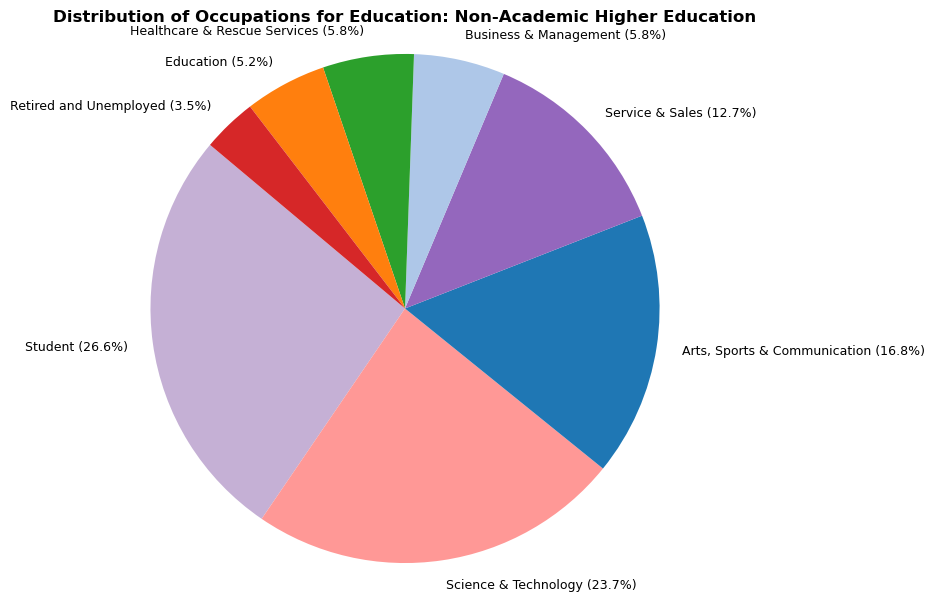

**occupations not found in Non-Academic Higher Education:** Government, Legal

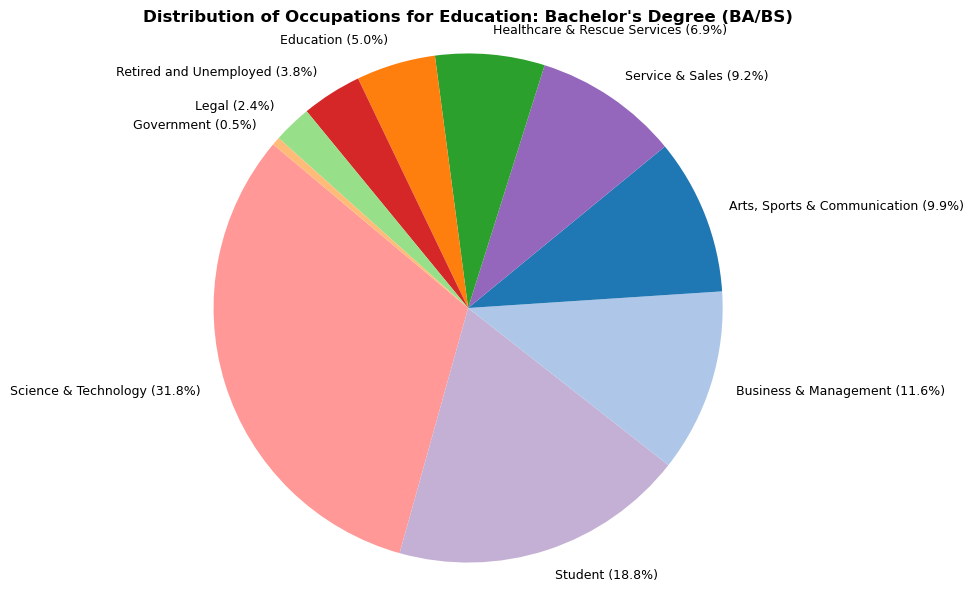

**occupations not found in Bachelor's Degree (BA/BS):** None

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# Create a color map for occupations
unique_occupations = count_df['Occupation'].unique()
colors = plt.get_cmap('tab20').colors  # Use a colormap with enough colors
color_map = {occupation: colors[i % len(colors)] for i, occupation in enumerate(unique_occupations)}

# Define the order of education types
education_order = [
    'Elementary Education', 
    'Partial High School', 
    'High School Graduate', 
    'Non-Academic Higher Education', 
    'Bachelor\'s Degree (BA/BS)', 
    'Master\'s Degree OR Doctorate'
]

# List of all occupations
all_occupations = [
    'Healthcare & Rescue Services',
    'Education',
    'Student',
    'Science & Technology',
    'Business & Management',
    'Arts, Sports & Communication',
    'Legal',
    'Government',
    'Service & Sales',
    'Retired and Unemployed'
]

# Plot pie charts
for education in education_order:
    if education not in count_df['Education'].unique():
        continue  # Skip if there is no data for this education type

    edu_data = count_df[count_df['Education'] == education]
    
    # Sort data by percentage in descending order
    edu_data = edu_data.sort_values(by='Percentage', ascending=False)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Create pie chart with percentages in parentheses and consistent colors
    labels_with_percentages = [f'{occupation} ({percentage:.1f}%)' for occupation, percentage in zip(edu_data['Occupation'], edu_data['Percentage'])]
    pie_colors = [color_map[occupation] for occupation in edu_data['Occupation']]
    wedges, texts = ax.pie(
        edu_data['Count'], labels=labels_with_percentages, startangle=140, colors=pie_colors
    )
    
    # Adjust label sizes
    for text in texts:
        text.set_fontsize(9)  # Further reduced font size for labels
    
    # Set title with bold font and less padding
    ax.set_title(f'Distribution of Occupations for Education: {education}', fontsize=12, fontweight='bold', pad=5)
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Remove extra space using subplots_adjust
    plt.subplots_adjust(top=1, bottom=0.2)  # Adjust top and bottom margins to reduce gaps
    
    plt.show()
    
    # Find missing occupations for the current education type
    present_occupations = set(edu_data['Occupation'])
    missing_occupations = set(all_occupations) - present_occupations
    missing_occupations_str = ', '.join(missing_occupations)
    
    # Display the missing occupations with less space between elements
    display(Markdown(f"**occupations not found in {education}:** {missing_occupations_str if missing_occupations else 'None'}"))


# Performing ANOVA Test

In [3]:
# ANOVA test & show in a table & Color Significance cells
model = ols('Count ~ C(Occupation) + C(Education)', data=count_df).fit()
anova_table_raw = sm.stats.anova_lm(model, type=2)

def highlight_significant(p_value, threshold=0.05):
    color = 'background-color: #80aaff' if p_value < threshold else ''
    return color
anova_table_styled = anova_table_raw.style.applymap(highlight_significant, subset=['PR(>F)'])

display(Markdown("### ANOVA Results: Analyzing the Effect of Education and Occupation"))
display(anova_table_styled)
print('Significant cells are highlighted in color.\n')

occupation_p_value = anova_table_raw.at['C(Occupation)', 'PR(>F)']
education_p_value = anova_table_raw.at['C(Education)', 'PR(>F)']

### ANOVA Results: Analyzing the Effect of Education and Occupation

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),9.000000,23681.953333,2631.328148,3.918404,0.001608
C(Education),5.000000,25412.094897,5082.418979,7.568410,0.000066
Residual,35.000000,23503.571770,671.530622,nan,nan


Significant cells are highlighted in color.



# Performing Tukey's Test

In [4]:
# Perform Post Hoc tests
if occupation_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Occupation"))
    tukey_results_prof = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Occupation'], alpha=0.05)
    tukey_results_prof_df = pd.DataFrame(tukey_results_prof.summary().data[1:], columns=tukey_results_prof.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == True]
    reject_false_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == False]

    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

if education_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Education"))
    tukey_results_education = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Education'], alpha=0.05)
    tukey_results_education_df = pd.DataFrame(tukey_results_education.summary().data[1:], columns=tukey_results_education.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_education_df[tukey_results_education_df['reject'] == True]
    reject_false_df = tukey_results_education_df[tukey_results_education_df['reject'] == False]
    
    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

### Post-Hoc Test (Tukey's HSD) for Occupation

'No relevant cases for this scenario (Reject = True)'

**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,"Arts, Sports & Communication",Business & Management,1.000000,1.000000,-66.591700,68.591700,False
1,"Arts, Sports & Communication",Education,-8.133300,1.000000,-79.024200,62.757500,False
2,"Arts, Sports & Communication",Government,-20.333300,0.997800,-103.116000,62.449300,False
3,"Arts, Sports & Communication",Healthcare & Rescue Services,-1.733300,1.000000,-72.624200,69.157500,False
4,"Arts, Sports & Communication",Legal,-16.666700,0.999500,-99.449300,66.116000,False
5,"Arts, Sports & Communication",Retired and Unemployed,-14.133300,0.999600,-85.024200,56.757500,False
6,"Arts, Sports & Communication",Science & Technology,42.833300,0.524000,-24.758400,110.425100,False
7,"Arts, Sports & Communication",Service & Sales,1.166700,1.000000,-66.425100,68.758400,False
8,"Arts, Sports & Communication",Student,46.266700,0.482900,-24.624200,117.157500,False
9,Business & Management,Education,-9.133300,1.000000,-80.024200,61.757500,False


### Post-Hoc Test (Tukey's HSD) for Education

**Reject = True:**

,group1,group2,meandiff,p-adj,lower,upper,reject
4,Bachelor's Degree (BA/BS),Partial High School,-54.314300,0.034400,-106.020000,-2.608500,True


**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Bachelor's Degree (BA/BS),Elementary Education,-56.000000,0.060000,-113.467700,1.467700,False
1,Bachelor's Degree (BA/BS),High School Graduate,-18.800000,0.837500,-65.722200,28.122200,False
2,Bachelor's Degree (BA/BS),Master's Degree OR Doctorate,-25.700000,0.582700,-72.622200,21.222200,False
3,Bachelor's Degree (BA/BS),Non-Academic Higher Education,-35.975000,0.280100,-85.743500,13.793500,False
5,Elementary Education,High School Graduate,37.200000,0.399200,-20.267700,94.667700,False
6,Elementary Education,Master's Degree OR Doctorate,30.300000,0.621600,-27.167700,87.767700,False
7,Elementary Education,Non-Academic Higher Education,20.025000,0.916300,-39.789300,79.839300,False
8,Elementary Education,Partial High School,1.685700,1.000000,-59.749900,63.121300,False
9,High School Graduate,Master's Degree OR Doctorate,-6.900000,0.997800,-53.822200,40.022200,False
10,High School Graduate,Non-Academic Higher Education,-17.175000,0.905900,-66.943500,32.593500,False
